In this nb, we compare the attributions values for the SN10 between the different tasks.

- We have the same positive dataset always, so the correlations are computed per positive part of dataset.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json

from scipy.stats import pearsonr, spearmanr

import torch
import torch.nn as nn
import torch.nn.functional as F

import logomaker

from NegativeClassOptimization import ml, visualisations
from NegativeClassOptimization import config, utils
from NegativeClassOptimization import preprocessing, datasets

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [2]:
from utils_07 import load_energy_contributions_from_task_nonlinear_version
from utils_07 import get_attr_from_records, get_onehotstack_from_records

In [3]:
FORCE_RUN = False


def local_task_generator(ag):
    
    task_types= [
        datasets.ClassificationTaskType.ONE_VS_ONE,
        datasets.ClassificationTaskType.ONE_VS_NINE,
        datasets.ClassificationTaskType.HIGH_VS_95LOW,
        datasets.ClassificationTaskType.HIGH_VS_LOOSER,
    ]
    
    for task_type in task_types:   
    
        if task_type != datasets.ClassificationTaskType.ONE_VS_ONE:

            task = datasets.ClassificationTask(
                task_type=task_type,
                ag_pos=ag,
                ag_neg="auto",
                seed_id=seed_id,
                split_id=split_id,
            )
            task = loader.load(task, attributions_toload="v2.0-2", attribution_records_toload="attribution_records_augmented.json")
            yield task

        else:

            for ag_neg in config.ANTIGENS:
                if ag_neg == ag:
                    continue

                task = datasets.ClassificationTask(
                    task_type=task_type,
                    ag_pos=ag,
                    ag_neg=ag_neg,
                    seed_id=seed_id,
                    split_id=split_id,
                )
                task = loader.load(task, attributions_toload="v2.0-2", attribution_records_toload="attribution_records_augmented.json")
                yield task



loader = datasets.FrozenMiniAbsolutMLLoader(
    data_dir=Path("../data/Frozen_MiniAbsolut_ML/")
)

df_path = Path("07e_df_attr.csv")


if df_path.exists() and not FORCE_RUN:
    df = pd.read_csv(df_path)
else:
    seed_id = 0
    split_id = 42
    attributor_name = "DeepLIFT_LOCAL_v2.0-2"
    dfs = []
    for ag in config.ANTIGENS:
        
        df = pd.DataFrame()
        
        for task in local_task_generator(ag):

            attr_stack = get_attr_from_records(
                task.attributions, attributor_name, (0, 1)  # type: ignore
            )  # Nx11x20 # type: ignore
            onehot_stack = get_onehotstack_from_records(
                task.attributions, (0, 1)  # type: ignore
            )  # Nx220 # type: ignore
            attr_aa = attr_stack[onehot_stack.reshape((-1, 11, 20)) == 1].reshape(
                -1, 11
            )  # Nx11

            
            df_i = pd.DataFrame.from_records(task.attributions)
            df_i["ag"] = ag
            
            if task.task_type == datasets.ClassificationTaskType.ONE_VS_ONE:
                task_type_str = f"{task.task_type.to_str()}_{task.ag_neg}"
            else:
                task_type_str = task.task_type.to_str()

            col_aa = f"attr_aa_{task_type_str}"
            col_logits = f"logits_{task_type_str}"
            
            df_i[col_aa] = [arr for arr in attr_aa]
            df_i[col_logits] = df_i["logits"]

            df_i.query("y_true == 1", inplace=True)
            df_i = df_i[["slide", "ag", col_aa, col_logits]]

            if df.shape[0] == 0:
                df = df_i
            else:
                df = pd.merge(df, df_i, on=["slide", "ag"], how="inner")
        dfs.append(df)

    df = pd.concat(dfs, axis=0)
    df = df.reset_index(drop=True)
    df.to_csv(df_path, index=False)

In [4]:
df

,slide,ag,attr_aa_1v1_1NSN,logits_1v1_1NSN,attr_aa_1v1_3RAJ,logits_1v1_3RAJ,attr_aa_1v1_5E94,logits_1v1_5E94,attr_aa_1v1_1H0D,logits_1v1_1H0D,...,attr_aa_1v1_1OB1,logits_1v1_1OB1,attr_aa_1v9,logits_1v9,attr_aa_high_vs_95low,logits_high_vs_95low,attr_aa_high_vs_looser,logits_high_vs_looser,attr_aa_1v1_3VRL,logits_1v1_3VRL
0,IWGYYFIFAYW,3VRL,[ 6.25880051 1.29771066 -0.87524509 1.652711...,41.387680,[-0.38153723 -1.01802278 1.75323904 -1.244398...,5.172563,[-0.01071292 -1.52626562 4.2434535 0.401634...,13.098495,[ 5.93111324 -1.8899672 -3.00128889 -0.567526...,25.042418,...,[ 2.95929003 1.96136343 -1.15330005 -1.339585...,22.372887,[ 0.88342285 -0.34466964 0.61083525 -0.417179...,13.974650,[ 4.64539576 1.02687728 -0.31168222 1.459461...,27.939528,[ 1.68517423 0.04048157 -0.37094995 0.514650...,17.467257,NaN,NaN
1,CARLMRLLYYF,3VRL,[ 3.5386498 -0.07549949 3.53257298 5.264244...,40.546093,[ 1.27361703e+00 -7.22850144e-01 8.74212444e-...,6.838865,[ 1.30705416 0.29149762 2.81324577 -0.412989...,8.655979,[ 5.69168806 -0.84766406 -2.22127104 3.447553...,18.791794,...,[ 0.98945951 -0.70923537 1.72324216 1.131215...,25.258099,[ 0.93776482 -0.82059497 0.33149499 1.267759...,13.850471,[ 3.62813306 0.19730565 -0.20123959 7.321004...,27.723316,[ 1.85076678e+00 -1.99476331e-01 4.72837269e-...,15.713529,NaN,NaN
2,CACLLCWFAYW,3VRL,[ 2.91202593 -0.01775175 4.94879818 6.509207...,40.161476,[ 1.42007124 0.19991712 2.34723616 3.153624...,6.317558,[ 0.82764351 -0.04917822 0.85226381 1.174771...,6.706130,[ 5.05710697 -0.99854052 1.22911942 4.590546...,17.954531,...,[ 0.95950335 -1.129246 -0.36521417 2.702858...,21.038343,[ 1.29217935 -0.38461354 2.00374031 2.663992...,8.158770,[ 3.30297279 0.46079078 1.36429441 6.024706...,29.705198,[ 0.65321559 -0.08126973 0.43003887 3.073230...,10.634475,NaN,NaN
3,CARVTFLLYWF,3VRL,[ 3.77828145 -0.22657713 2.60064602 2.144210...,39.846455,[ 1.98941326 -0.78086346 1.63386881 -0.869135...,13.853996,[ 2.67519426 2.28903151 4.68646717 1.206291...,18.200617,[ 5.54485989 -0.98009998 -1.74687004 -1.399099...,42.725887,...,[ 1.86165118 -1.08139622 1.89768851 -0.081803...,36.802307,[ 1.68712616 -0.71336067 0.68063599 0.106320...,22.842293,[ 3.16867399 0.22964844 -0.135627 5.279823...,44.041523,[ 2.19027209 -0.11974746 0.56299037 2.086099...,29.994934,NaN,NaN
4,CVRLCYLFAYW,3VRL,[ 2.48737788 0.13478103 2.12913132 4.869723...,38.811222,[ 2.62475967 1.11795354 1.08166134 2.413312...,18.653202,[ 1.97818947 -0.92023164 4.91303825 1.062143...,15.179201,[ 6.08855724 -2.12109804 -1.30056477 4.807538...,21.491158,...,[ 1.24504876 0.79283345 1.5451889 0.417055...,18.016665,[ 1.67726743 0.41216534 -0.0727639 1.792448...,14.929591,[ 2.93856955 4.31443691 -0.47273698 6.266701...,28.437613,[ 2.2288487 -0.02241447 0.5674907 2.610432...,15.724460,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,GIPFLLLHYFD,1OB1,[-1.63081574 -1.48725712 0.55451041 0.782927...,-0.603558,[-0.82002628 -1.28822601 -1.51775491 0.308611...,-9.793861,[ 0.00425138 -1.90520668 0.99885112 0.148654...,-2.663035,[-2.72298169 -1.80615425 -1.89254534 1.773911...,-0.831709,...,NaN,NaN,[-1.71184194 -0.66560823 -0.96510756 0.734254...,-5.997962,[ 0.02531038 0.40651774 0.32411376 1.168015...,6.923419,[-1.67204833 -0.8085494 -1.64580691 -0.064233...,-5.885361,[ 1.18536401 -1.9982388 -0.58810937 -0.989327...,-5.179731
49996,YVGLHWYFDVW,1OB1,[ 2.21783614 -1.58041263 -1.92149162 2.454761...,1.197719,[ 1.26940513 -2.40235782 3.58572698 0.895014...,2.615638,[ 1.00707793 -1.27873933 5.5735054 -1.099044...,2.284410,[ 4.13563442 -2.68749261 -3.84266853 3.247451...,7.936324,...,NaN,NaN,[ 2.16498852 0.01434449 -0.73479992 2.259453...,1.053642,[ 3.40815496 1.25724244 -2.06386805 7.813964...,13.612244,[ 1.89407158 0.26320827 0.10979006 1.553451...,3.524334,[ 2.72808337 -3.347435 -0.29212248 -3.790658...,-5.243629
49997,LLWYPLGFAYW,1OB1,[ 0.06863592 -2.12981391 -0.66203576 -0.830250...,3.351259,[ 2.79154754 -2.20171595 -2.54090333 -1.10884

In [5]:
def process_str_to_list_floats(s):
    
    if type(s) == float:
        return np.nan
    if type(s) == list:
        return s
    
    vals = []
    for ch in s.replace("\n", "").strip("[] ").split(" "):
        if ch == "":
            continue
        vals.append(float(ch))
    assert len(vals) == 11
    return vals

df["attr_aa_high_vs_looser"] = df["attr_aa_high_vs_looser"].apply(process_str_to_list_floats) 
df["attr_aa_high_vs_95low"] = df["attr_aa_high_vs_95low"].apply(process_str_to_list_floats)
df["attr_aa_1v9"] = df["attr_aa_1v9"].apply(process_str_to_list_floats)

for ag in config.ANTIGENS:
    df[f"attr_aa_1v1_{ag}"] = df[f"attr_aa_1v1_{ag}"].apply(process_str_to_list_floats)

In [6]:
df["corr_attr_looser_95low"] = df.apply(lambda row: pearsonr(row["attr_aa_high_vs_looser"], row["attr_aa_high_vs_95low"])[0], axis=1)
df["corr_attr_9_looser"] = df.apply(lambda row: pearsonr(row["attr_aa_1v9"], row["attr_aa_high_vs_looser"])[0], axis=1) 
df["corr_attr_9_95low"] = df.apply(lambda row: pearsonr(row["attr_aa_1v9"], row["attr_aa_high_vs_95low"])[0], axis=1)

In [7]:
# Computing correlations between 1v1 tasks and the others is
# a bit more involved, since there are multiple 1v1 tasks.
# We compute the average correlation between all 1v1 tasks and the other tasks.

def pearson_r_nanomitting(x, y):
    if not np.isnan(x).any() and not np.isnan(y).any():
        return pearsonr(x, y)[0]
    else:
        return np.nan

corr_attr_1v1_looser = []
corr_attr_1v1_95low = []
corr_attr_1v1_9 = []
for ag in config.ANTIGENS:
    corr_attr_1v1_looser.append(df.apply(lambda row: pearson_r_nanomitting(row[f"attr_aa_1v1_{ag}"], row["attr_aa_high_vs_looser"]), axis=1))
    corr_attr_1v1_95low.append(df.apply(lambda row: pearson_r_nanomitting(row[f"attr_aa_1v1_{ag}"], row["attr_aa_high_vs_95low"]), axis=1))
    corr_attr_1v1_9.append(df.apply(lambda row: pearson_r_nanomitting(row[f"attr_aa_1v1_{ag}"], row["attr_aa_1v9"]), axis=1))


df["corr_attr_1v1_looser"] = np.nanmean(corr_attr_1v1_looser, axis=0)
df["corr_attr_1v1_95low"] = np.nanmean(corr_attr_1v1_95low, axis=0)
df["corr_attr_1v1_9"] = np.nanmean(corr_attr_1v1_9, axis=0)

df

,slide,ag,attr_aa_1v1_1NSN,logits_1v1_1NSN,attr_aa_1v1_3RAJ,logits_1v1_3RAJ,attr_aa_1v1_5E94,logits_1v1_5E94,attr_aa_1v1_1H0D,logits_1v1_1H0D,...,attr_aa_high_vs_looser,logits_high_vs_looser,attr_aa_1v1_3VRL,logits_1v1_3VRL,corr_attr_looser_95low,corr_attr_9_looser,corr_attr_9_95low,corr_attr_1v1_looser,corr_attr_1v1_95low,corr_attr_1v1_9
0,IWGYYFIFAYW,3VRL,"[6.25880051, 1.29771066, -0.87524509, 1.652711...",41.387680,"[-0.38153723, -1.01802278, 1.75323904, -1.2443...",5.172563,"[-0.01071292, -1.52626562, 4.2434535, 0.401634...",13.098495,"[5.93111324, -1.8899672, -3.00128889, -0.56752...",25.042418,...,"[1.68517423, 0.04048157, -0.37094995, 0.514650...",17.467257,NaN,NaN,0.912402,0.928265,0.938976,0.711341,0.678344,0.716588
1,CARLMRLLYYF,3VRL,"[3.5386498, -0.07549949, 3.53257298, 5.2642440...",40.546093,"[1.27361703, -0.722850144, 0.874212444, 0.5813...",6.838865,"[1.30705416, 0.29149762, 2.81324577, -0.412989...",8.655979,"[5.69168806, -0.84766406, -2.22127104, 3.44755...",18.791794,...,"[1.85076678, -0.199476331, 0.472837269, 2.0532...",15.713529,NaN,NaN,0.904392,0.948350,0.879410,0.848292,0.792118,0.856630
2,CACLLCWFAYW,3VRL,"[2.91202593, -0.01775175, 4.94879818, 6.509207...",40.161476,"[1.42007124, 0.19991712, 2.34723616, 3.1536247...",6.317558,"[0.82764351, -0.04917822, 0.85226381, 1.174771...",6.706130,"[5.05710697, -0.99854052, 1.22911942, 4.590546...",17.954531,...,"[0.65321559, -0.08126973, 0.43003887, 3.073230...",10.634475,NaN,NaN,0.738760,0.880318,0.600205,0.664968,0.537891,0.623969
3,CARVTFLLYWF,3VRL,"[3.77828145, -0.22657713, 2.60064602, 2.144210...",39.846455,"[1.98941326, -0.78086346, 1.63386881, -0.86913...",13.853996,"[2.67519426, 2.28903151, 4.68646717, 1.2062914...",18.200617,"[5.54485989, -0.98009998, -1.74687004, -1.3990...",42.725887,...,"[2.19027209, -0.11974746, 0.56299037, 2.086099...",29.994934,NaN,NaN,0.894199,0.857030,0.834701,0.631768,0.573386,0.667848
4,CVRLCYLFAYW,3VRL,"[2.48737788, 0.13478103, 2.12913132, 4.8697233...",38.811222,"[2.62475967, 1.11795354, 1.08166134, 2.4133124...",18.653202,"[1.97818947, -0.92023164, 4.91303825, 1.062143...",15.179201,"[6.08855724, -2.12109804, -1.30056477, 4.80753...",21.491158,...,"[2.2288487, -0.02241447, 0.5674907, 2.61043286...",15.724460,NaN,NaN,0.829051,0.882874,0.870857,0.669064,0.556679,0.663018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,GIPFLLLHYFD,1OB1,"[-1.63081574, -1.48725712, 0.55451041, 0.78292...",-0.603558,"[-0.82002628, -1.28822601, -1.51775491, 0.3086...",-9.793861,"[0.00425138, -1.90520668, 0.99885112, 0.148654...",-2.663035,"[-2.72298169, -1.80615425, -1.89254534, 1.7739...",-0.831709,...,"[-1.67204833, -0.8085494, -1.64580691, -0.0642...",-5.885361,"[1.18536401, -1.9982388, -0.58810937, -0.98932...",-5.179731,-0.249454,0.677871,0.224674,0.465417,-0.061528,0.429411
49996,YVGLHWYFDVW,1OB1,"[2.21783614, -1.58041263, -1.92149162, 2.45476...",1.197719,"[1.26940513, -2.40235782, 3.58572698, 0.895014...",2.615638,"[1.00707793, -1.27873933, 5.5735054, -1.099044...",2.284410,"[4.13563442, -2.68749261, -3.84266853, 3.24745...",7.936324,...,"[1.89407158, 0.26320827, 0.10979006, 1.5534513...",3.524334,"[2.72808337, -3.347435, -0.29212248, -3.790658...",-5.243629,0.861282,0.923689,0.875642,0.421603,0.350989,0.512031
49997,LLWYPLGFAYW,1OB1,"[0.06863592, -2.12981391, -0.66203576, -0.8302...",3.351259,"[2.79154754, -2.20171595, -2.54090333, -1.1088...",-8.201902,"[0.33375558, -1.40269947, 0.39313591, -0.08097...",1.604180,"[4.36274672, -2.36024976, 2.23863983, -0.12205...",15.741571,...,"[0.42142496, -1.01750922, -0.44817796, 0.06003...",1.011629,"[-1.48084044, -4.49267292, 1.65800536, 0.30309...",-6.171167,0.718502,0.647173,0.674502,0.347776,0.341645,0.424419
49998,CAFWLLPLQYF,1OB1,"[1.70316219, -0.60580868, 0.47650164, -0.53308...",7.198455,"[1.53693509, 1.01619697, 1.11695504, -0.490915...",-1.190683,"[-0.31493098, 0.68250489, -0.03512785, -0.2182...",11.873363,"[2.74629045, 0.696675122, 3.46815681, 0

In [8]:
# Melt df across correlations
df_corr = df[["slide", "ag", "corr_attr_looser_95low", "corr_attr_9_looser", "corr_attr_9_95low",
              "corr_attr_1v1_looser", "corr_attr_1v1_95low", "corr_attr_1v1_9"]]
df_corr = df_corr.melt(id_vars=["slide", "ag"], var_name="corr_type", value_name="corr_value")
df_corr

,slide,ag,corr_type,corr_value
0,IWGYYFIFAYW,3VRL,corr_attr_looser_95low,0.912402
1,CARLMRLLYYF,3VRL,corr_attr_looser_95low,0.904392
2,CACLLCWFAYW,3VRL,corr_attr_looser_95low,0.738760
3,CARVTFLLYWF,3VRL,corr_attr_looser_95low,0.894199
4,CVRLCYLFAYW,3VRL,corr_attr_looser_95low,0.829051
...,...,...,...,...
299995,GIPFLLLHYFD,1OB1,corr_attr_1v1_9,0.429411
299996,YVGLHWYFDVW,1OB1,corr_attr_1v1_9,0.512031
299997,LLWYPLGFAYW,1OB1,corr_attr_1v1_9,0.424419
299998,CAFWLLPLQYF,1OB1,corr_attr_1v1_9,0.534351


In [21]:
map_to_clean = {
    "corr_attr_looser_95low": "vs Weak - vs Non-binder",
    "corr_attr_9_looser": "vs 9 - vs Weak",
    "corr_attr_9_95low": "vs 9 - vs Non-binder",
    "corr_attr_1v1_looser": "vs 1 - vs Weak",
    "corr_attr_1v1_95low": "vs 1 - vs Non-binder",
    "corr_attr_1v1_9": "vs 1 - vs 9",
}

df_corr["corr_type_clean"] = df_corr["corr_type"].apply(
    lambda s: map_to_clean[s]
    )

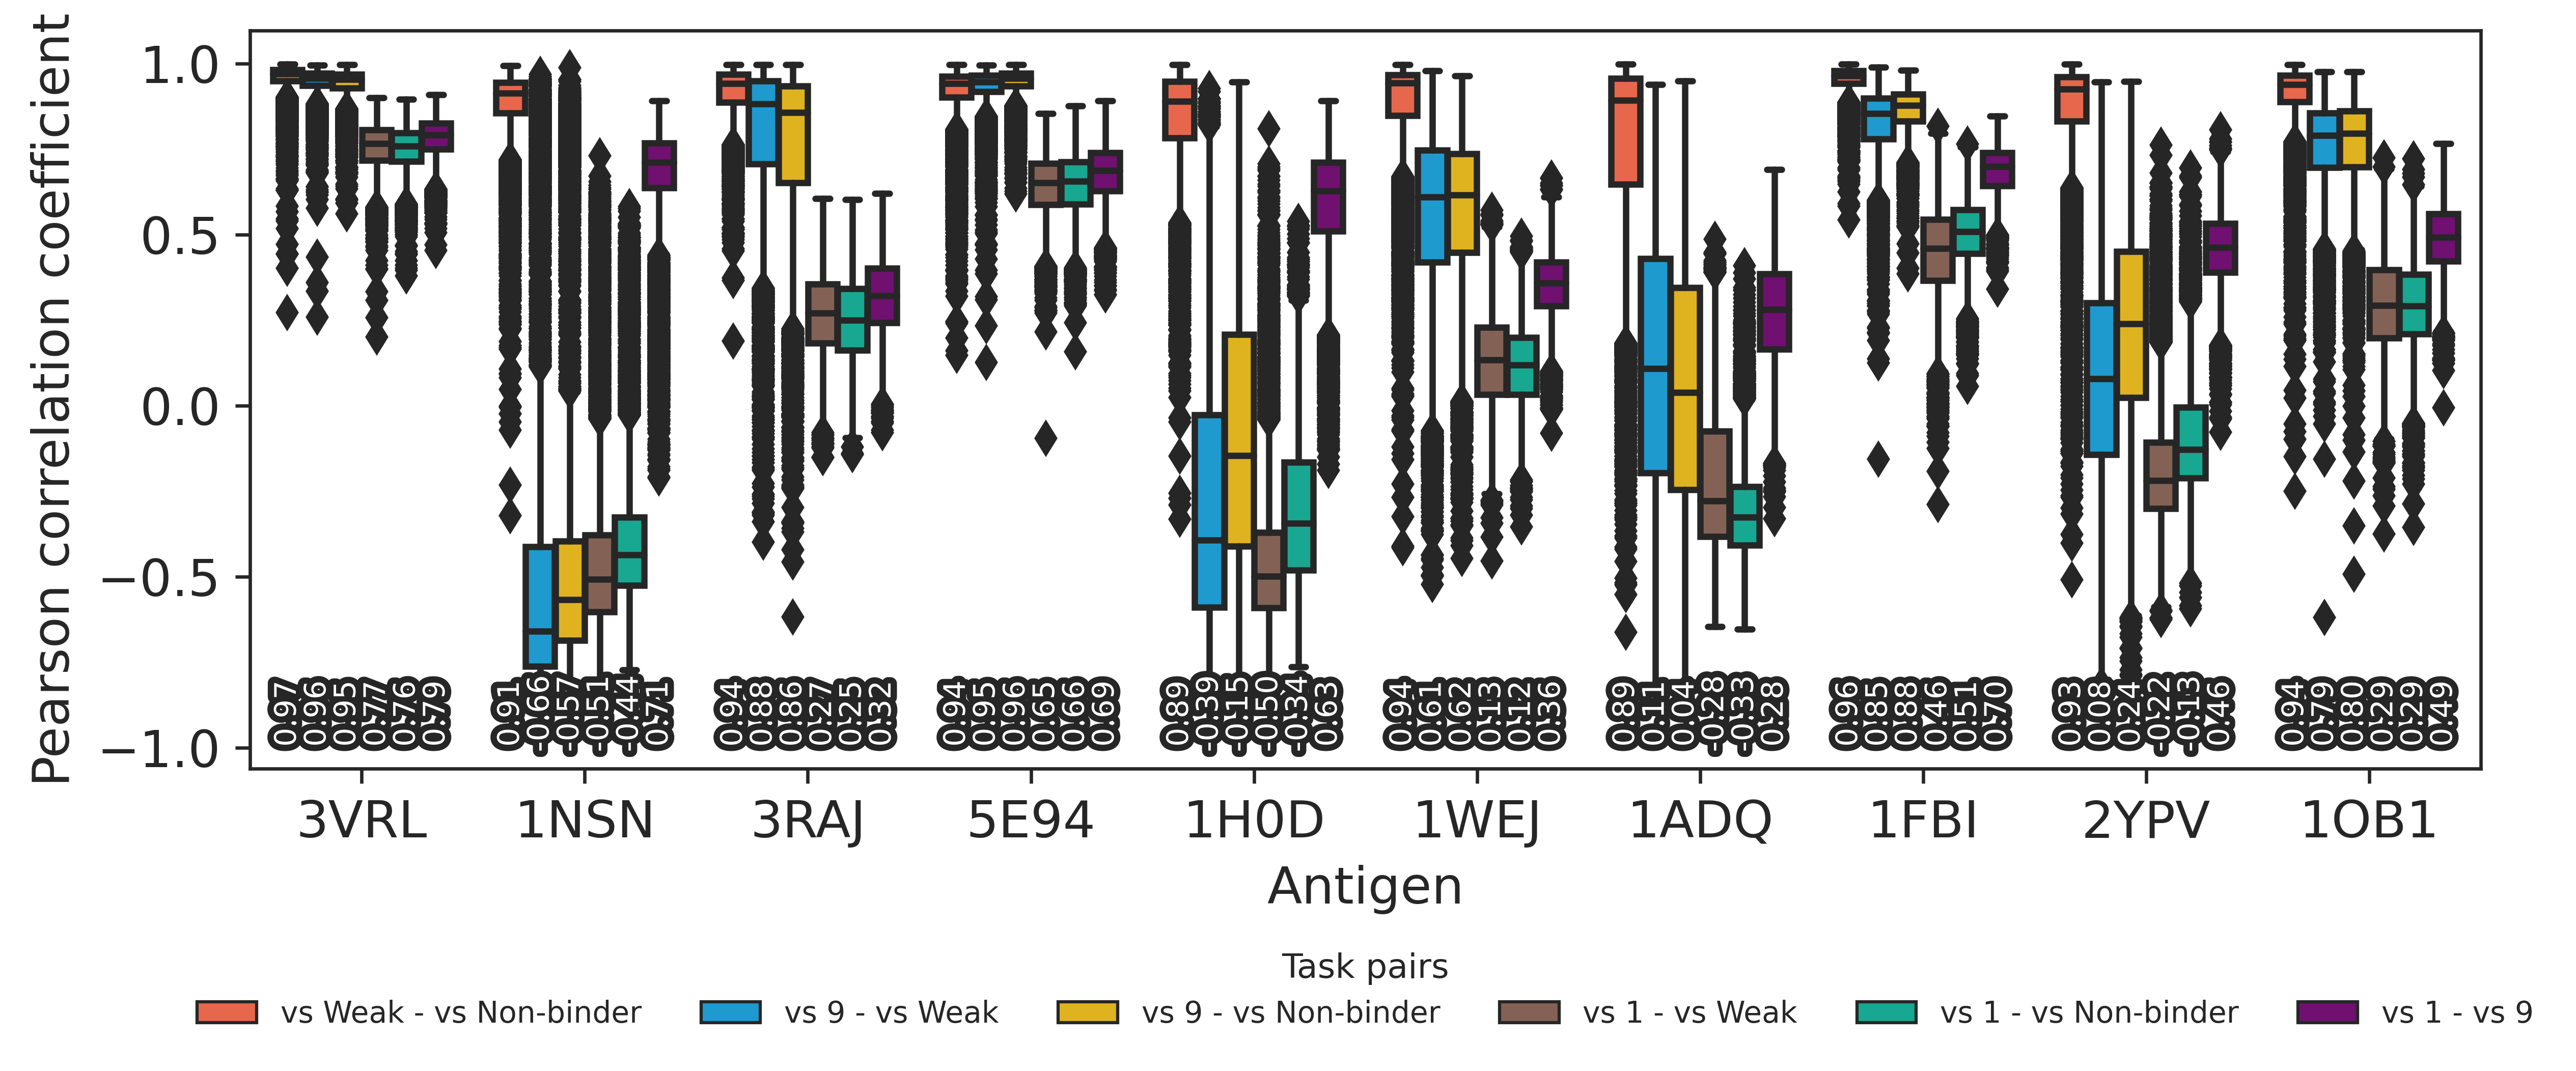

In [39]:
plt.rcParams['svg.fonttype'] = 'none' #saves text as text not object
sns.set_style("white")
sns.set_style('ticks')

fig, ax = plt.subplots(figsize=(3*3.14, 3.14), dpi=600)
sns.boxplot(
# sns.violinplot(
    data=df_corr,
    x="ag",
    y="corr_value",
    hue="corr_type_clean",
    palette=list(visualisations.FinalPlotParams.cmap_tasks.values()) + ["#800080"],
)

visualisations.add_median_labels(ax, y_level=-0.9, fontsize=7)

ax.tick_params(labelsize=12)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task pairs",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)

ax.set_xlabel("Antigen", fontsize=12)
ax.set_ylabel("Pearson correlation coefficient", fontsize=12)

fig.savefig("figures/Supp_Figure_8_A.svg")

In [10]:
df_corr

,slide,ag,corr_type,corr_value
0,IWGYYFIFAYW,3VRL,corr_attr_looser_95low,0.912402
1,CARLMRLLYYF,3VRL,corr_attr_looser_95low,0.904392
2,CACLLCWFAYW,3VRL,corr_attr_looser_95low,0.738760
3,CARVTFLLYWF,3VRL,corr_attr_looser_95low,0.894199
4,CVRLCYLFAYW,3VRL,corr_attr_looser_95low,0.829051
...,...,...,...,...
299995,GIPFLLLHYFD,1OB1,corr_attr_1v1_9,0.429411
299996,YVGLHWYFDVW,1OB1,corr_attr_1v1_9,0.512031
299997,LLWYPLGFAYW,1OB1,corr_attr_1v1_9,0.424419
299998,CAFWLLPLQYF,1OB1,corr_attr_1v1_9,0.534351


/tmp/ipykernel_9923/212709755.py:2: FutureWarning: ['slide'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_corr_g = df_corr.groupby(["ag", "corr_type"]).agg(["mean"]).round(2).unstack()


<AxesSubplot: xlabel='None-None-corr_type', ylabel='ag'>

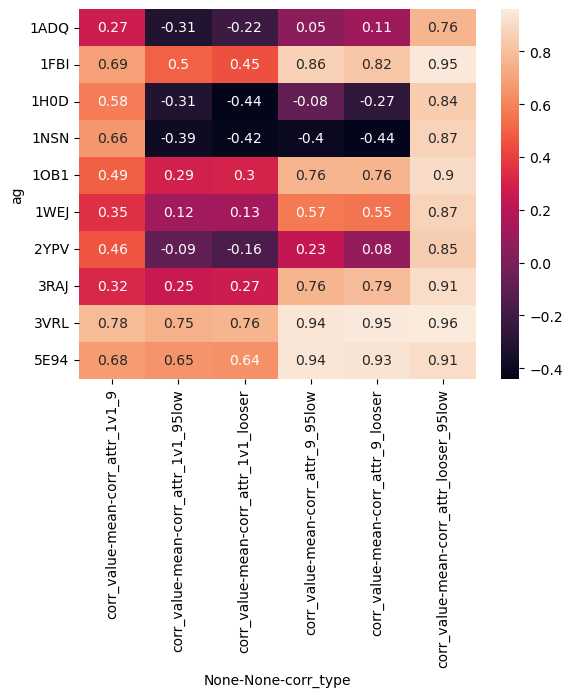

In [11]:
# Convert to heatmap, showing the numbers
df_corr_g = df_corr.groupby(["ag", "corr_type"]).agg(["mean"]).round(2).unstack()
sns.heatmap(
    df_corr_g,
    annot=True,
)

In [26]:
## Add the norm!
## Magnitude of attributions
df["attr_aa_high_vs_looser_mag"] = df["attr_aa_high_vs_looser"].apply(lambda x: np.linalg.norm(x, ord=2))
df["attr_aa_high_vs_95low_mag"] = df["attr_aa_high_vs_95low"].apply(lambda x: np.linalg.norm(x, ord=2))
df["attr_aa_1v9_mag"] = df["attr_aa_1v9"].apply(lambda x: np.linalg.norm(x, ord=2))

# Again 1v1 tasks are a bit more involved
def norm_nanhandling(x):
    if np.isnan(x).any():
        return np.nan
    else:
        return np.linalg.norm(x, ord=2)

attr_1v1_mag = []
for ag in config.ANTIGENS:
    attr_1v1_mag.append(df[f"attr_aa_1v1_{ag}"].apply(lambda x: norm_nanhandling(x)))
df["attr_aa_1v1_mag"] = np.nanmean(attr_1v1_mag, axis=0)


df_mag = df[["slide", "ag", "attr_aa_high_vs_looser_mag", "attr_aa_high_vs_95low_mag", "attr_aa_1v9_mag", "attr_aa_1v1_mag"]]
df_mag = df_mag.melt(id_vars=["slide", "ag"], var_name="attr_type", value_name="attr_value")

KeyError: 'attr_aa_high_vs_looser'

In [30]:
map_to_clean = {
    "attr_aa_high_vs_looser_mag": "vs Weak",
    "attr_aa_high_vs_95low_mag": "vs Non-binder",
    "attr_aa_1v9_mag": "vs 9",
    "attr_aa_1v1_mag": "vs 1",

}

df_mag["attr_type_clean"] = df_mag["attr_type"].apply(
    lambda s: map_to_clean[s]
    )

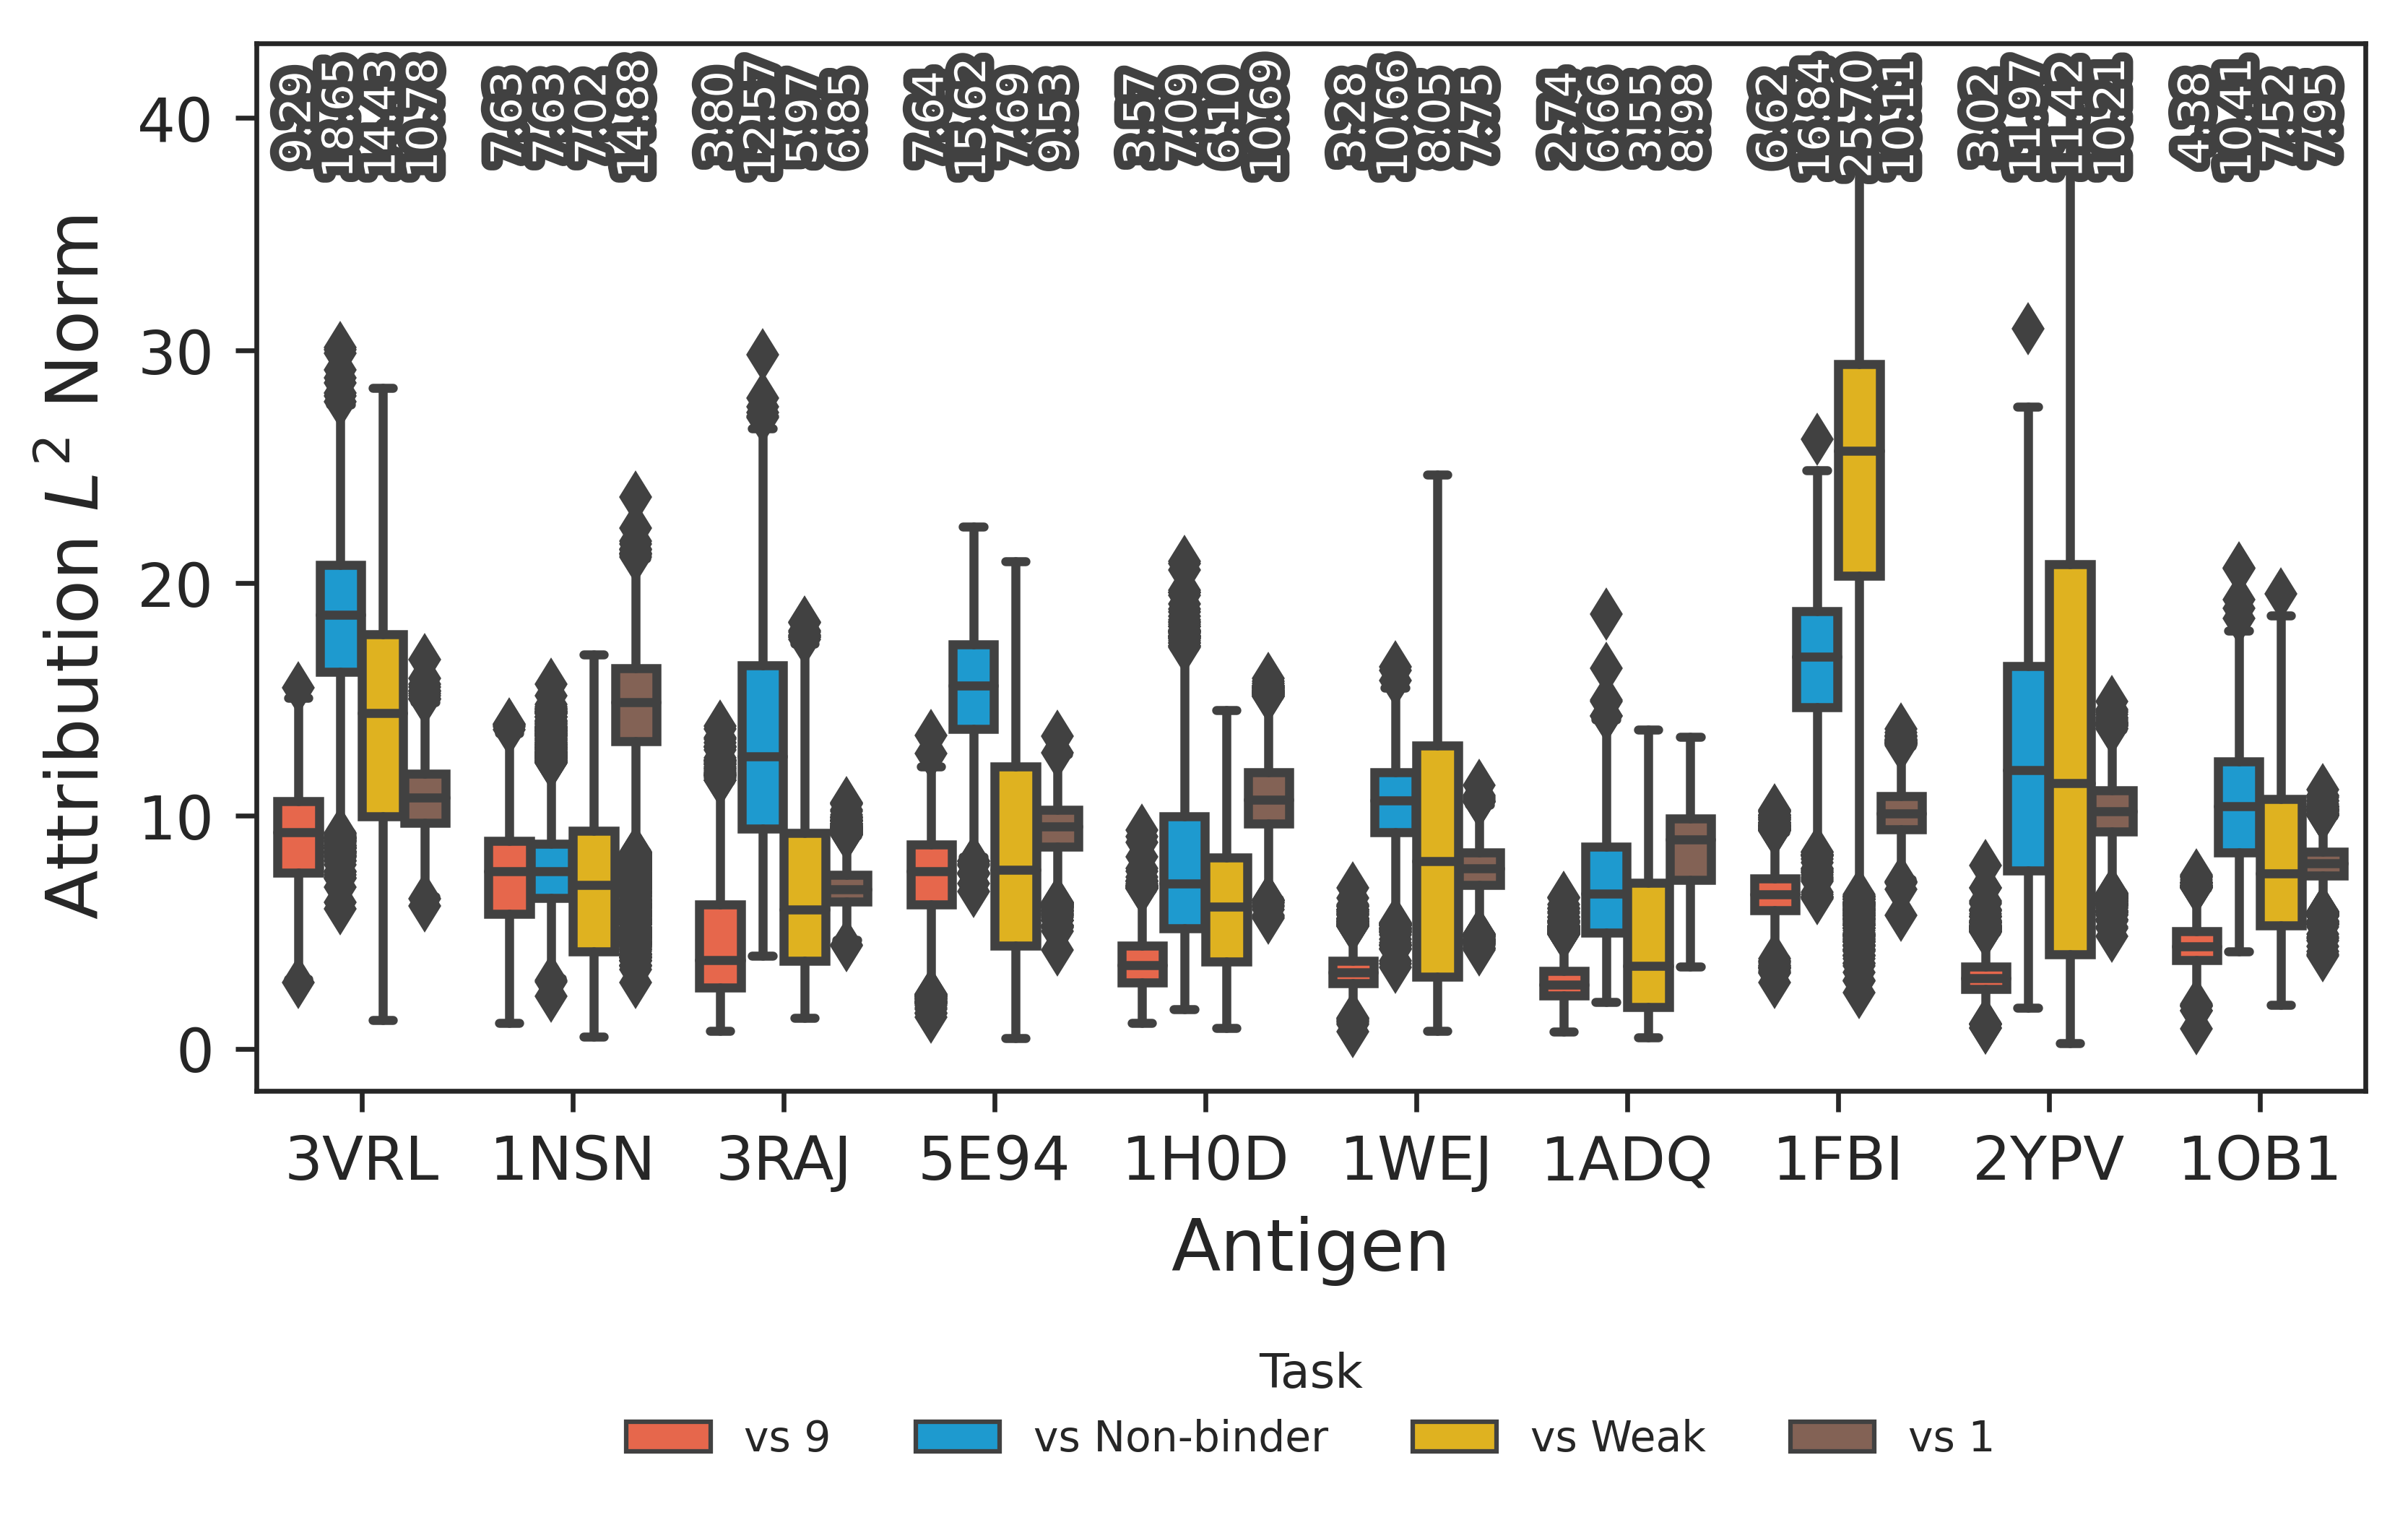

In [38]:
plt.rcParams['svg.fonttype'] = 'none' #saves text as text not object
sns.set_style("white")
sns.set_style('ticks')

fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)
sns.boxplot(
    data=df_mag,
    hue="attr_type_clean",
    y="attr_value",
    x="ag",
    ax=ax,
    hue_order=list(visualisations.FinalPlotParams.cmap_tasks.keys())[:-1],
    palette=list(visualisations.FinalPlotParams.cmap_tasks.values())[:-1],
)

visualisations.add_median_labels(ax, y_level=40, fontsize=7)

ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)

ax.set_xlabel("Antigen", fontsize=12)
ax.set_ylabel("Attribution $L^2$ Norm", fontsize=12)

fig.savefig("figures/Supp_Figure_8_B.svg")

Model weights

In [13]:
task_types= [
    datasets.ClassificationTaskType.ONE_VS_NINE,
    datasets.ClassificationTaskType.HIGH_VS_95LOW,
    datasets.ClassificationTaskType.HIGH_VS_LOOSER,
]

loader = datasets.FrozenMiniAbsolutMLLoader(
    data_dir=Path("../data/Frozen_MiniAbsolut_ML/")
)


seed_id = 0
split_id = 42
records = []
for ag in config.ANTIGENS:
    
    df = pd.DataFrame()
    for task_type in task_types:   
        task = datasets.ClassificationTask(
            task_type=task_type,
            ag_pos=ag,
            ag_neg="auto",
            seed_id=seed_id,
            split_id=split_id,
        )
        
        task = loader.load(task, attributions_toload="v2.0-2", load_model=True)
        # Add model complexity
        L1_w = task.model.module.linear_1.weight
        L2_w = task.model.module.linear_2.weight
        L1_norm = L1_w.norm()
        L2_norm = L2_w.norm()
        records.append({
            "ag": ag,
            "ag_neg": "auto",
            "task_type": task_type.to_str(),
            "L1_norm": L1_norm,
            "L2_norm": L2_norm,
            "SN10_norm": L1_norm + L2_norm,
        })

KeyboardInterrupt: 

In [ ]:
# Add 1v1

for ag in config.ANTIGENS:
    for ag_neg in config.ANTIGENS:
        if ag_neg == ag:
            continue
        task = datasets.ClassificationTask(
            task_type=datasets.ClassificationTaskType.ONE_VS_ONE,
            ag_pos=ag,
            ag_neg=ag_neg,
            seed_id=seed_id,
            split_id=split_id,
        )
        task = loader.load(task, attributions_toload="v2.0-2", load_model=True)
        # Add model complexity
        L1_w = task.model.module.linear_1.weight
        L2_w = task.model.module.linear_2.weight
        L1_norm = L1_w.norm()
        L2_norm = L2_w.norm()
        records.append({
            "ag": ag,
            "ag_neg": ag_neg,
            "task_type": "1v1",
            "L1_norm": L1_norm,
            "L2_norm": L2_norm,
            "SN10_norm": L1_norm + L2_norm,
        })

In [ ]:
df_norms = pd.DataFrame.from_records(records)
df_norms["SN10_norm"] = df_norms["SN10_norm"].apply(lambda x: x.item())
df_norms["L1_norm"] = df_norms["L1_norm"].apply(lambda x: x.item())
df_norms["L2_norm"] = df_norms["L2_norm"].apply(lambda x: x.item())
df_norms.head()

,ag,ag_neg,task_type,L1_norm,L2_norm,SN10_norm
0,3VRL,auto,1v9,27.650110,7.238309,34.888420
1,3VRL,auto,high_vs_95low,24.919481,8.731784,33.651264
2,3VRL,auto,high_vs_looser,32.371429,9.706873,42.078300
3,1NSN,auto,1v9,29.746561,8.653611,38.400173
4,1NSN,auto,high_vs_95low,26.225658,6.482751,32.708408


<AxesSubplot: xlabel='L1_norm', ylabel='L2_norm'>

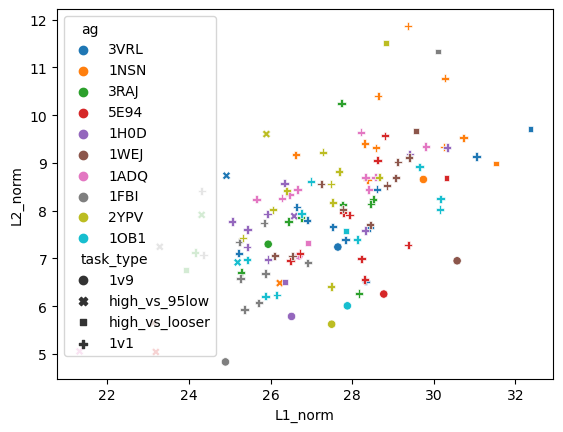

In [ ]:
sns.scatterplot(
    data=df_norms,
    x="L1_norm",
    y="L2_norm",
    hue="ag",
    style="task_type",
)

<AxesSubplot: xlabel='ag', ylabel='SN10_norm'>

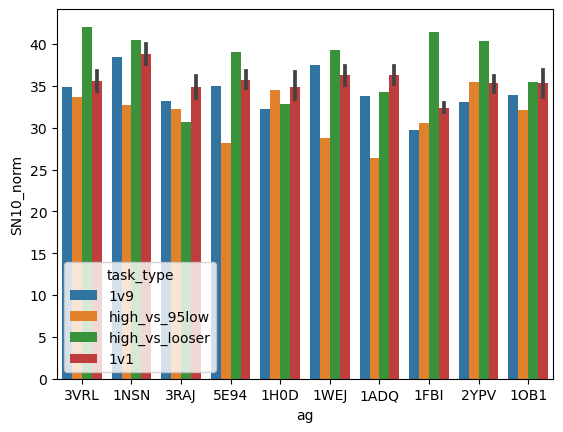

In [ ]:
sns.barplot(
    data=df_norms,
    hue="task_type",
    y="SN10_norm",
    x="ag"
)

<AxesSubplot: xlabel='ag', ylabel='L1_norm'>

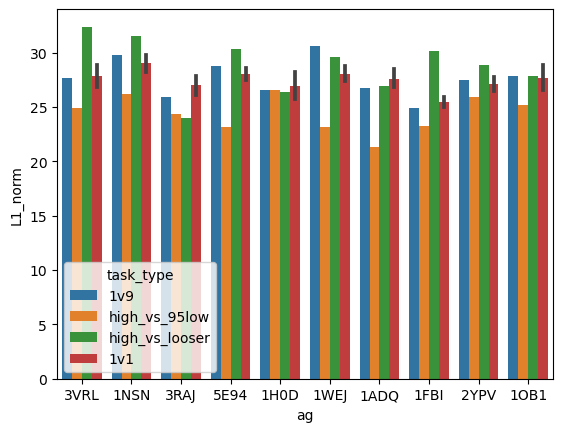

In [ ]:
sns.barplot(
    data=df_norms,
    hue="task_type",
    y="L1_norm",
    x="ag"
)

<AxesSubplot: xlabel='ag', ylabel='L2_norm'>

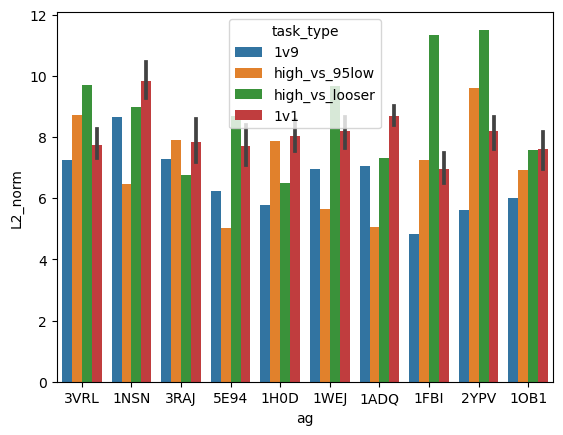

In [ ]:
sns.barplot(
    data=df_norms,
    hue="task_type",
    y="L2_norm",
    x="ag"
)